# Titanik

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import matplotlib.colors as colors
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
rd_seed = 40
import warnings

## Předzpracování dat

In [2]:
def splitData(data):
    Xdata = data.drop("survived", axis=1)
    ydata = data["survived"]
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        Xdata, ydata, test_size=0.3, random_state=rd_seed
    )
    Xval, Xtest, yval, ytest = train_test_split(
        Xtest, ytest, test_size=0.5, random_state=rd_seed
    )
    return Xtrain, ytrain, Xval, yval, Xtest, ytest

In [3]:
data = pd.read_csv("01/data.csv")
Xtrain, ytrain, Xval, yval, Xtest, ytest = splitData(data)

In [4]:
display(Xtrain.info())
Xtrain.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 154 to 326
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         700 non-null    int64  
 1   pclass     700 non-null    int64  
 2   name       700 non-null    object 
 3   sex        700 non-null    object 
 4   age        557 non-null    float64
 5   sibsp      700 non-null    int64  
 6   parch      700 non-null    int64  
 7   ticket     700 non-null    object 
 8   fare       700 non-null    float64
 9   cabin      163 non-null    object 
 10  embarked   700 non-null    object 
 11  home.dest  394 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 71.1+ KB


None

,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
154,154,1,"Chevre, Mr. Paul Romaine",male,45.0,0,0,PC 17594,29.7000,A9,C,"Paris, France"
715,715,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.5500,NaN,S,London
680,680,1,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C62 C64,C,"New York, NY"
129,129,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,NaN
760,760,1,"Cumings, Mr. John Bradley",male,39.0,1,0,PC 17599,71.2833,C85,C,"New York, NY"


In [5]:
def missingValuesGraph(df, name):
    fig, ax = plt.subplots(figsize=(16, 6))
    cmap = colors.ListedColormap(["darkslategrey", "white"])
    ax.imshow(
        df.isna(),
        aspect="auto",
        cmap=cmap,
        interpolation="none",
        vmin=0,
        vmax=1,
    )
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows Index")

    num_columns = len(df.columns)

    ax.set_xticks(np.arange(num_columns))
    ax.tick_params(axis="x", which="major", length=0)
    ax.set_xticklabels(df.columns, rotation=45, ha="right")

    ax.set_xticks(np.arange(0.5, num_columns + 0.5, 1), minor=True)

    legend_elements = [
        Patch(facecolor="darkslategrey", edgecolor="black", label="Present Value"),
        Patch(facecolor="white", edgecolor="black", label="Missing Value"),
    ]

    ax.legend(
        handles=legend_elements,
        loc="upper right",
        bbox_to_anchor=(1.05, -0.1),
        borderaxespad=0.0,
    )

    ax.grid(
        which="minor",
        visible=True,
        axis="x",
        color="white",
        linestyle="-",
        linewidth=1.0,
    )
    ax.grid(
        which="major",
        visible=False,
        axis="x",
    )

    ax.grid(
        which="major",
        visible=False,
        axis="y",
    )

    ax.set_yticks(range(0, len(df), max(1, len(df) // 5)))
    ax.set_title(f"Missing Values in {name}")

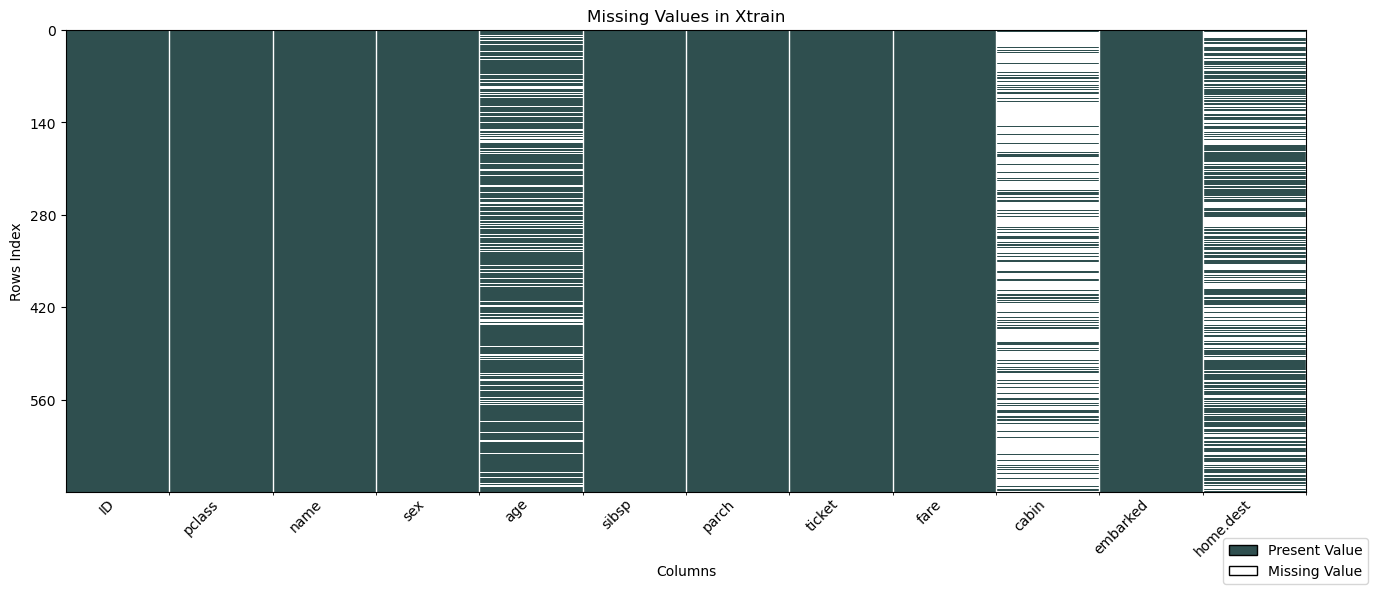

In [6]:
missingValuesGraph(Xtrain, "Xtrain")

Přírpava dat pro rozhodovací strom. Vynechám sloupce name, id, ticket, protože jsou skoro unikátní hodnoty, které nepřidávají mnoho další informace. Sloupce cabin a home.dest mají hodně chybějících hodnot, takže je taky odstraním. Sloupce sex a embarked jsou nominální kategorické, použiji tedy one-hot encoding.

In [7]:
def preprocessTree(df):
    df = df.drop(["ID", "name", "cabin", "home.dest", "ticket"], axis=1)
    df = pd.get_dummies(df, columns=["sex", "embarked"])
    df = df.fillna(-1)
    return df

### Metoda k-nejbližších sousedů

Nejprve zjistím jaký rozsah a distribuci mají číselné spojité příznaky. 

Stejně jako v případě stromového klasifikátoru vynecháním sloupce ID, name, cabin, home.dest, ticket. 

In [8]:
def hist_box(df, cont_col):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.histplot(df[cont_col], bins=30, kde=False, ax=ax[0])
    ax[0].set_title(f"{cont_col.capitalize()} Distribution in Dataset")
    ax[0].set_xlabel(cont_col.capitalize())
    ax[0].set_ylabel("Frequency")

    sns.boxplot(x=df[cont_col], ax=ax[1])
    ax[1].set_title(f"Box Plot of {cont_col.capitalize()} in Dataset")
    ax[1].set_xlabel(cont_col.capitalize())

    plt.tight_layout()
    plt.show()
    display(df[cont_col].describe())

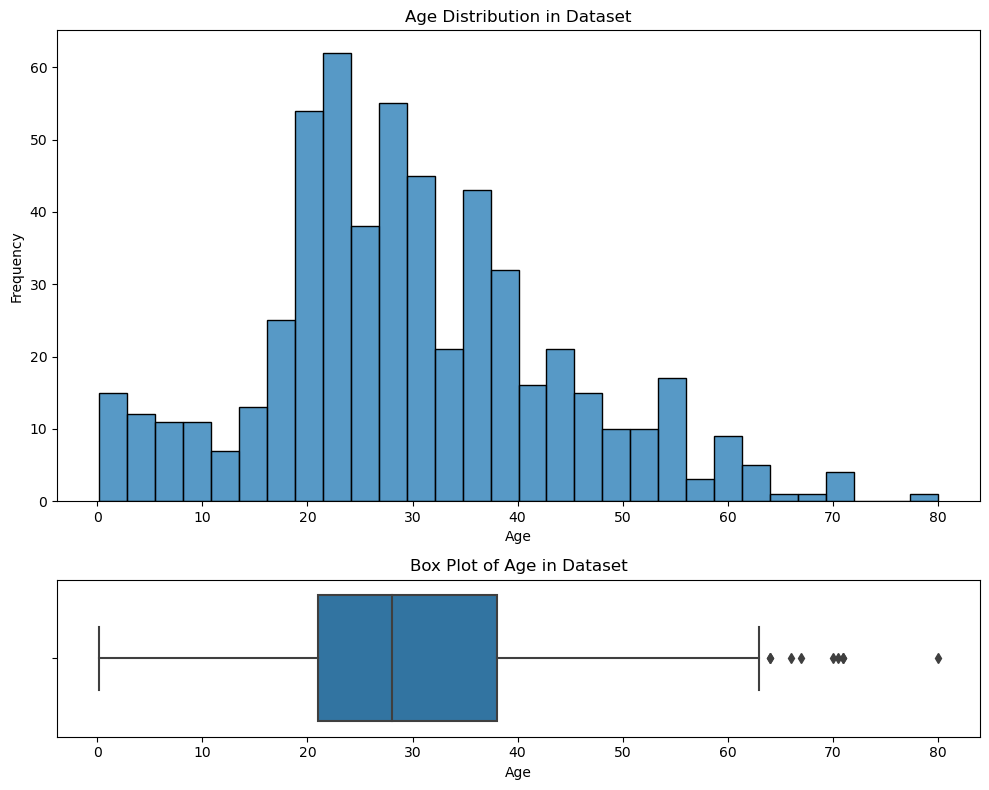

count    557.000000
mean      29.897217
std       14.138091
min        0.166700
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

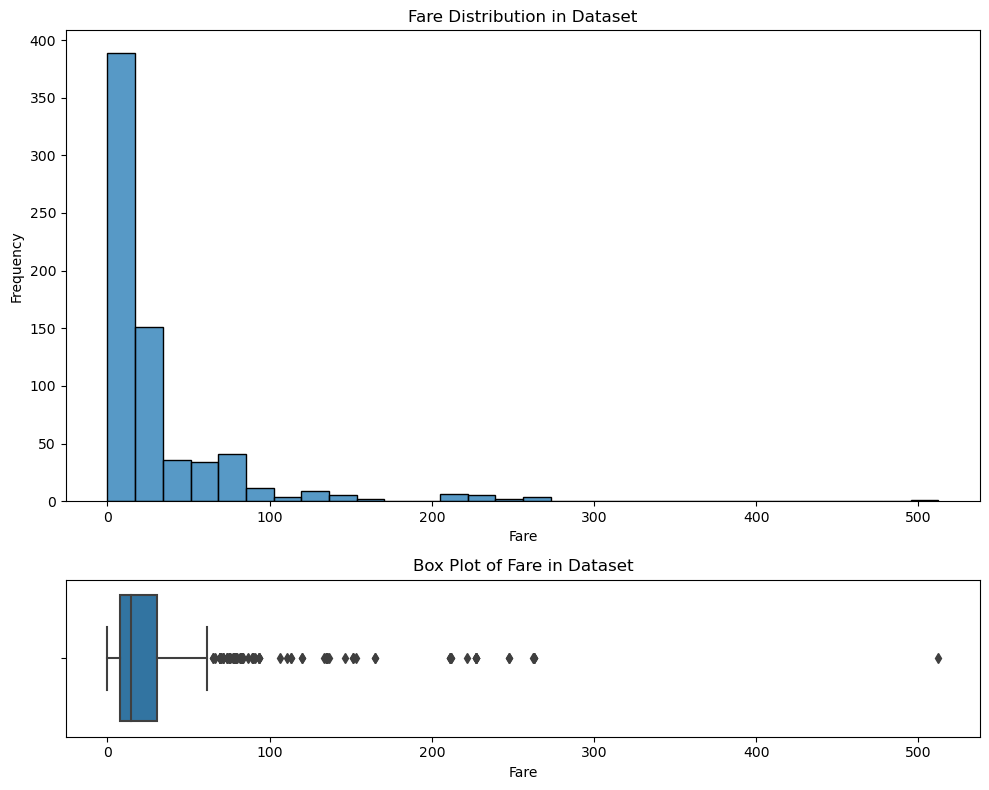

count    700.000000
mean      31.703154
std       46.223490
min        0.000000
25%        7.895800
50%       14.500000
75%       30.500000
max      512.329200
Name: fare, dtype: float64

In [9]:
hist_box(Xtrain, "age")
hist_box(Xtrain, "fare")

In [10]:
Xtrain["parch"].unique()

array([0, 2, 1, 3, 4, 9, 5, 6])

In [11]:
Xtrain["sibsp"].unique()

array([0, 1, 8, 2, 3, 5, 4])

Příznaky mají rozdílné rozsahy hodnot, proto použiji MinMax normalizaci na tyto příznaky.

In [12]:
def applyTransform(df, scaler, encoder):
    df = df.fillna(-1)
    df[["age", "fare",  "sibsp", "parch"]] = scaler.transform(df[["age", "fare",  "sibsp", "parch"]])
    
    encoded_array = encoder.transform(df[["sex", "embarked", "pclass"]])
    encoded_columns = encoder.get_feature_names_out(["sex", "embarked", "pclass"])
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df.index)
    df = pd.concat([df, encoded_df], axis=1).drop(["sex", "embarked", "pclass"], axis=1)

    df = df.drop(["ID", "name", "cabin", "home.dest", "ticket"], axis=1)
    df = df.fillna(-1)
    return df

def preprocessKNN(Xtrain, Xval, Xtest):
    scaler = MinMaxScaler().fit(Xtrain[["age", "fare",  "sibsp", "parch"]])
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(Xtrain[["sex", "embarked", "pclass"]])
    Xtrain = applyTransform(Xtrain, scaler, encoder)
    Xval = applyTransform(Xval, scaler, encoder)
    Xtest = applyTransform(Xtest, scaler, encoder)
    return Xtrain, Xval, Xtest

V případě numerický příznaků fare, age, sibsp, parch jsem provedl MinMax normalizaci. 

Doplnění chybějících hodnot příznaku age jsem doplnil na -1, škálování jsem provedl až potom.

## Trénink

### Rozhodovací strom

In [13]:
XtrainTree = preprocessTree(Xtrain)
XvalTree = preprocessTree(Xval)
XtestTree = preprocessTree(Xtest)

param_grid = {
    "max_depth": range(2,8),
    "min_samples_split": range(2,20),
    "min_samples_leaf": range(1, 10),
    "criterion": ["gini", "entropy"]
}
param_comb = ParameterGrid(param_grid)

val_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(**params)
    dt.fit(XtrainTree, ytrain)
    val_acc.append(metrics.accuracy_score(yval, dt.predict(XvalTree)))

best_params = param_comb[np.argmax(val_acc)]
print("best params ", best_params)
dt = DecisionTreeClassifier(**best_params)
dt.fit(XtrainTree, ytrain)
print(
    "accuracy score (train): {0:.6f}".format(
        metrics.accuracy_score(ytrain, dt.predict(XtrainTree))
    )
)
print(
    "accuracy score (validation): {0:.6f}".format(
        metrics.accuracy_score(yval, dt.predict(XvalTree))
    )
)

best params  {'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 7, 'criterion': 'gini'}
accuracy score (train): 0.855714
accuracy score (validation): 0.820000


### KNN

In [14]:
XtrainKNN, XvalKNN, XtestKNN = preprocessKNN(Xtrain, Xval, Xtest) 

warnings.simplefilter(action='ignore', category=FutureWarning) 

val_acc = []
train_acc = []

param_grid = {
    "n_neighbors": range(2, 20),
    "weights": ["distance", "uniform"],
    "p": range(1,3),
    "metric": ["chebyshev", "minkowski"]
}
param_comb = ParameterGrid(param_grid)
clf = KNeighborsClassifier()
for params in param_comb:
    clf = KNeighborsClassifier(**params)
    clf.fit(XtrainKNN, ytrain)
    val_acc.append(clf.score(XvalKNN, yval))
    train_acc.append(clf.score(XtrainKNN, ytrain))

best_params = param_comb[np.argmax(val_acc)]
print("best params ", best_params)

clf = KNeighborsClassifier(**best_params)
clf.fit(XtrainKNN, ytrain)

print(
    "accuracy score (train): {0:.6f}".format(
        metrics.accuracy_score(ytrain, clf.predict(XtrainKNN))
    )
)
print(
    "accuracy score (validation): {0:.6f}".format(
        metrics.accuracy_score(yval, clf.predict(XvalKNN))
    )
)

best params  {'weights': 'uniform', 'p': 1, 'n_neighbors': 11, 'metric': 'minkowski'}
accuracy score (train): 0.828571
accuracy score (validation): 0.806667


## Srovnání a výběr modelu

### Statistiky

Nejprve vypočtu pro každý model matici záměn a z ní spočítám přesnost, f1 skóre. Poté vykreslím ROC křivku a spočítám AUC. Na základě vypočítaných statistik vyberu finální model.

In [15]:
#matice záměn
def print_metrics(ytest, ypred):
    cf = metrics.confusion_matrix(ytest, ypred)
    cf_r = metrics.confusion_matrix(ytest, ypred, normalize="true")
    
    cf_df = pd.DataFrame(cf, index=["Skutečnost - False", "Skutečnost - True"], columns=["Predikce - False", "Predikce - True"])
    cf_r_df = pd.DataFrame(cf_r, index=["Skutečnost - False", "Skutečnost - True"], columns=["Predikce - False", "Predikce - True"])
    
    # Display the matrices
    print("Normalizovaná matice záměn:")
    display(cf_r_df)
    print("Matice záměn:")
    display(cf_df)
    
    # Print metrics
    print(f"TPR = {cf_r[1,1]:.4f}\nFNR = {cf_r[1,0]:.4f}\nFPR = {cf_r[0,1]:.4f}\nTNR = {cf_r[0,0]:.4f}")
    print(f"Accuracy: {metrics.accuracy_score(ytest, ypred):.4f}")
    print(f"F1 Score: {metrics.f1_score(ytest, ypred):.4f}")


print("==========================================")
print("Rozhodovací strom:")
print_metrics(yval, dt.predict(XvalTree))

print("==========================================")
print("KNN:")
print_metrics(yval, clf.predict(XvalKNN))

Rozhodovací strom:
Normalizovaná matice záměn:


,Predikce - False,Predikce - True
Skutečnost - False,0.898876,0.101124
Skutečnost - True,0.295082,0.704918


Matice záměn:


,Predikce - False,Predikce - True
Skutečnost - False,80,9
Skutečnost - True,18,43


TPR = 0.7049
FNR = 0.2951
FPR = 0.1011
TNR = 0.8989
Accuracy: 0.8200
F1 Score: 0.7611
KNN:
Normalizovaná matice záměn:


,Predikce - False,Predikce - True
Skutečnost - False,0.865169,0.134831
Skutečnost - True,0.278689,0.721311


Matice záměn:


,Predikce - False,Predikce - True
Skutečnost - False,77,12
Skutečnost - True,17,44


TPR = 0.7213
FNR = 0.2787
FPR = 0.1348
TNR = 0.8652
Accuracy: 0.8067
F1 Score: 0.7521


In [16]:
def printROC(model, yval, Xval):
    y_pred_proba = model.predict_proba(Xval)
    p1_hat = y_pred_proba[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(yval, p1_hat)
    AUC = metrics.roc_auc_score(yval, y_pred_proba[:,1])

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC křivka (AUC = {AUC:.3f})")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC křivka")
    ax.legend(loc="lower right")
    plt.show()

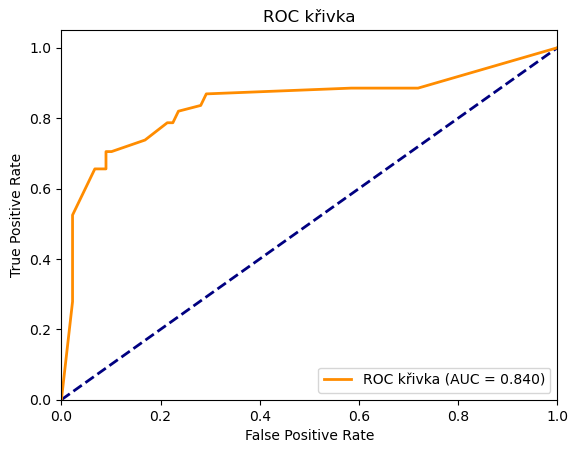

In [17]:
printROC(dt, yval, XvalTree)

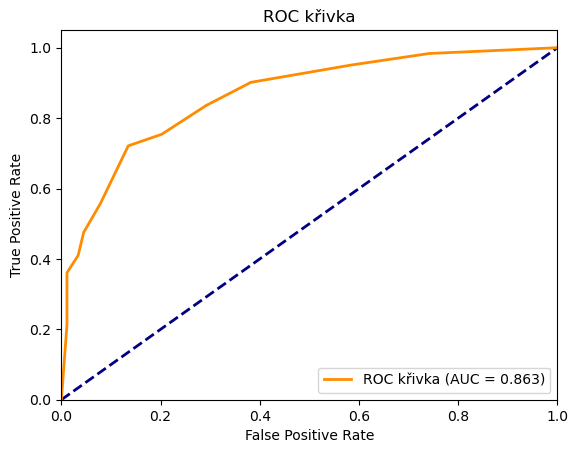

In [18]:
printROC(clf, yval, XvalKNN)

### Diskuze

Jako finální model zvolím KNN, protože má vyšší AUC na validační množině, i když má o něco horší přesnost. KNN lépe predikuje, že člověk přežije, za to strom je lepší v predikci, že člověk zemře. Nicméně rozdíl mezi modely je velmi malý.

Pomocí testovacích dat, které jsme si odložili na začátku můžeme odhadnout přesnost finálního modelu na nových datech.

In [19]:
print("Statistiky na testovacích datech:")
print_metrics(ytest,  clf.predict(XtestKNN))

Statistiky na testovacích datech:
Normalizovaná matice záměn:


,Predikce - False,Predikce - True
Skutečnost - False,0.911111,0.088889
Skutečnost - True,0.300000,0.700000


Matice záměn:


,Predikce - False,Predikce - True
Skutečnost - False,82,8
Skutečnost - True,18,42


TPR = 0.7000
FNR = 0.3000
FPR = 0.0889
TNR = 0.9111
Accuracy: 0.8267
F1 Score: 0.7636


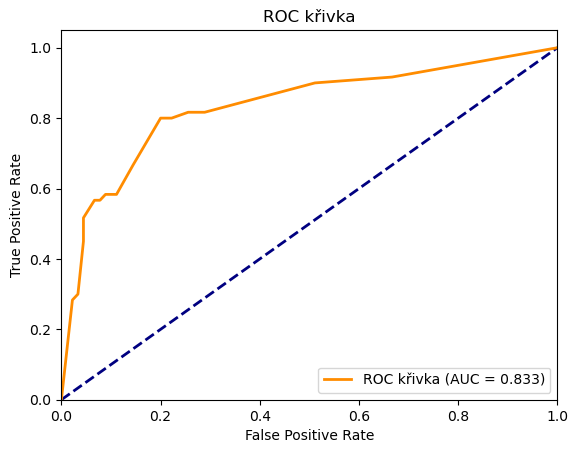

In [20]:
printROC(dt, ytest, XtestTree)

## Vyhodnocovací data

In [22]:
#předzpracování
data = pd.read_csv("01/evaluation.csv")
scaler = MinMaxScaler().fit(Xtrain[["age", "fare",  "sibsp", "parch"]])
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(Xtrain[["sex", "embarked", "pclass"]])
Xevaluation = applyTransform(data, scaler, encoder)

result = pd.DataFrame({
    "ID": data["ID"],
    "survived": clf.predict(Xevaluation)})
result.to_csv("01/result.csv", index=False)